# Stakeholder

A real estate company is looking to invest in non-luxury, single-family homes in King County, WA. They think this market will grow over time. They want information on several factors that influence the price of such homes.

In [1202]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
import geopy.distance
from IPython.display import clear_output
from sklearn.model_selection import train_test_split

In [1203]:
houses = pd.read_csv("data/kc_house_data.csv")

# Functions

I list all the functions I use in this project here. As a result, the rest of the project will be more readable.

In [1204]:
def scatter(df, cols):
    fig, ax = plt.subplots(6,5, figsize=(25,20))
    fig.tight_layout(pad=3)

    for i in range(30):

        row = i//5
        col=i%5

        try:
            ax[row][col].scatter(df[cols[i]], df.price)
            ax[row][col].set_title(cols[i], size=15)
        except:
            break

In [1205]:
def hist(df, cols):
    fig, ax = plt.subplots(3,5, figsize=(25,10))
    fig.tight_layout(pad=5.0)

    for i in range(15):

        row = i//5
        col=i%5

        try:
            ax[row][col].hist(df[cols[i]], bins=100)
            ax[row][col].set_title(cols[i], size=25)
        except:
            break

In [1206]:
def value_counts(df):
    
    for col in df.columns:
        if df[col].nunique() < 100:
            value_counts = dict(df[col].value_counts())
            for key in value_counts.keys():
                if value_counts[key] <= 10:
                    df = df[~(df[col] == key)]
                
    return df

In [1207]:
def variable_strength(df, var_list):
    col_dict = {"variables": var_list, "rsquared_adj": []}

    for col in var_list:
        model = sm.OLS.from_formula(f"price ~ {col}", data=df)
        results = model.fit()
        col_dict["rsquared_adj"].append(results.rsquared_adj)

    return pd.DataFrame(col_dict).sort_values(by="rsquared_adj", ascending=False)

In [1208]:
def usable_vars(df, to_drop):
    print(f"The list of variables we can use in the linear regression model is: \n\n {list(df.drop(to_drop, axis=1).columns)}")

In [1209]:
def create_model(formula, df):
    model = sm.OLS.from_formula(formula, data=df)
    results = model.fit()
    print(results.summary())
    
    return results

In [1210]:
def analyze_model(results, df, log=False):
    
    if log==True:
        predicted = np.exp(results.predict(df))
        original = np.exp(df.price)
    else:
        predicted = results.predict(df)
        original = df.price
    
    fig = plt.figure(figsize =([25,15]))

    gs = gridspec.GridSpec(2, 3)

    ax1 = plt.subplot(gs[0, :])
    ax1.set_ylabel('ylabel', labelpad = 0, fontsize = 12)
    ax1.set_title("Predicted values vs. Actual Values")
    ax1.scatter(original, predicted, alpha=0.0375)
    ax1.set_title("Predicted values vs. actual values", fontsize=30)
    ax1.scatter(np.linspace(predicted.min(),predicted.max(),1000),
                np.linspace(predicted.min(),predicted.max(),1000), 
                color="black", s=2)

    ax2 = plt.subplot(gs[1, 0:1])
    ax2.set_ylabel('ylabel', labelpad = 0, fontsize = 12)
    ax2.set_title("QQ Plot")
    sm.graphics.qqplot(results.resid, dist=stats.norm, line='45', fit=True, ax=ax2, alpha=0.0375)
    line = ax2.lines[1]
    line.set_color("black")

    ax3 = plt.subplot(gs[1, 1:2])
    ax3.set_ylabel('ylabel', labelpad = 0, fontsize = 12)
    ax3.set_title("Residuals vs. Fitted Values")
    residuals = original - predicted
    ax3.scatter(predicted, residuals, alpha=0.0375)
    ax3.axhline(y=0, color='black', linestyle='-', linewidth=3)

    ax4 = plt.subplot(gs[1, 2:3])
    ax4.set_ylabel('ylabel', labelpad = 0, fontsize = 12)
    ax4.set_title("Histogram of Residuals")
    ax4.hist(residuals, color="green", bins=100)
    ax4.axhline(y=0, color="black")
    ax4.set_xlabel("y")
    ax4.set_ylabel("residuals")
    
    print("\n\n")
    mae = mean_absolute_error(original, predicted)
    rmse = mean_squared_error(original, predicted)
    print (f"MAE: {mae}\nRMSE: {rmse}")
    
    predict = {'residuals': np.abs(residuals), 'unusual': df.unusual}
    predictdf = pd.DataFrame(predict)
    print(f"Average error for normal houses: {predictdf[predictdf.unusual == 0].residuals.mean()}")
    print(f"Average error for unusual houses: {predictdf[predictdf.unusual == 1].residuals.mean()}")

    plt.show()

# Outliers

Some of these distributions have extreme outliers. By looking at histograms for each variable (which I will not include here to make the project more readable), I found that:

- Any price above 10,000,000 or under 300,000 is likely an outlier
- A range of 600-7500 square footage of living space is "normal" for houses
- A similar range of 250-6500 for square footage above grade
- Anything less than 500,000 square footage of lot space
- Anything less than 1500 square footage of patio space
- The third-party API providing latitude/longitutde data accidentally returned several values outside of King County, WA, which is the subject of this project. Anything outside shouldn't be counted.
    - A very close approximation to the boundaries of King County, WA is determined by:
        - A longitude between -125 and -121.6
        - A latitude between 47.1 and 47.8

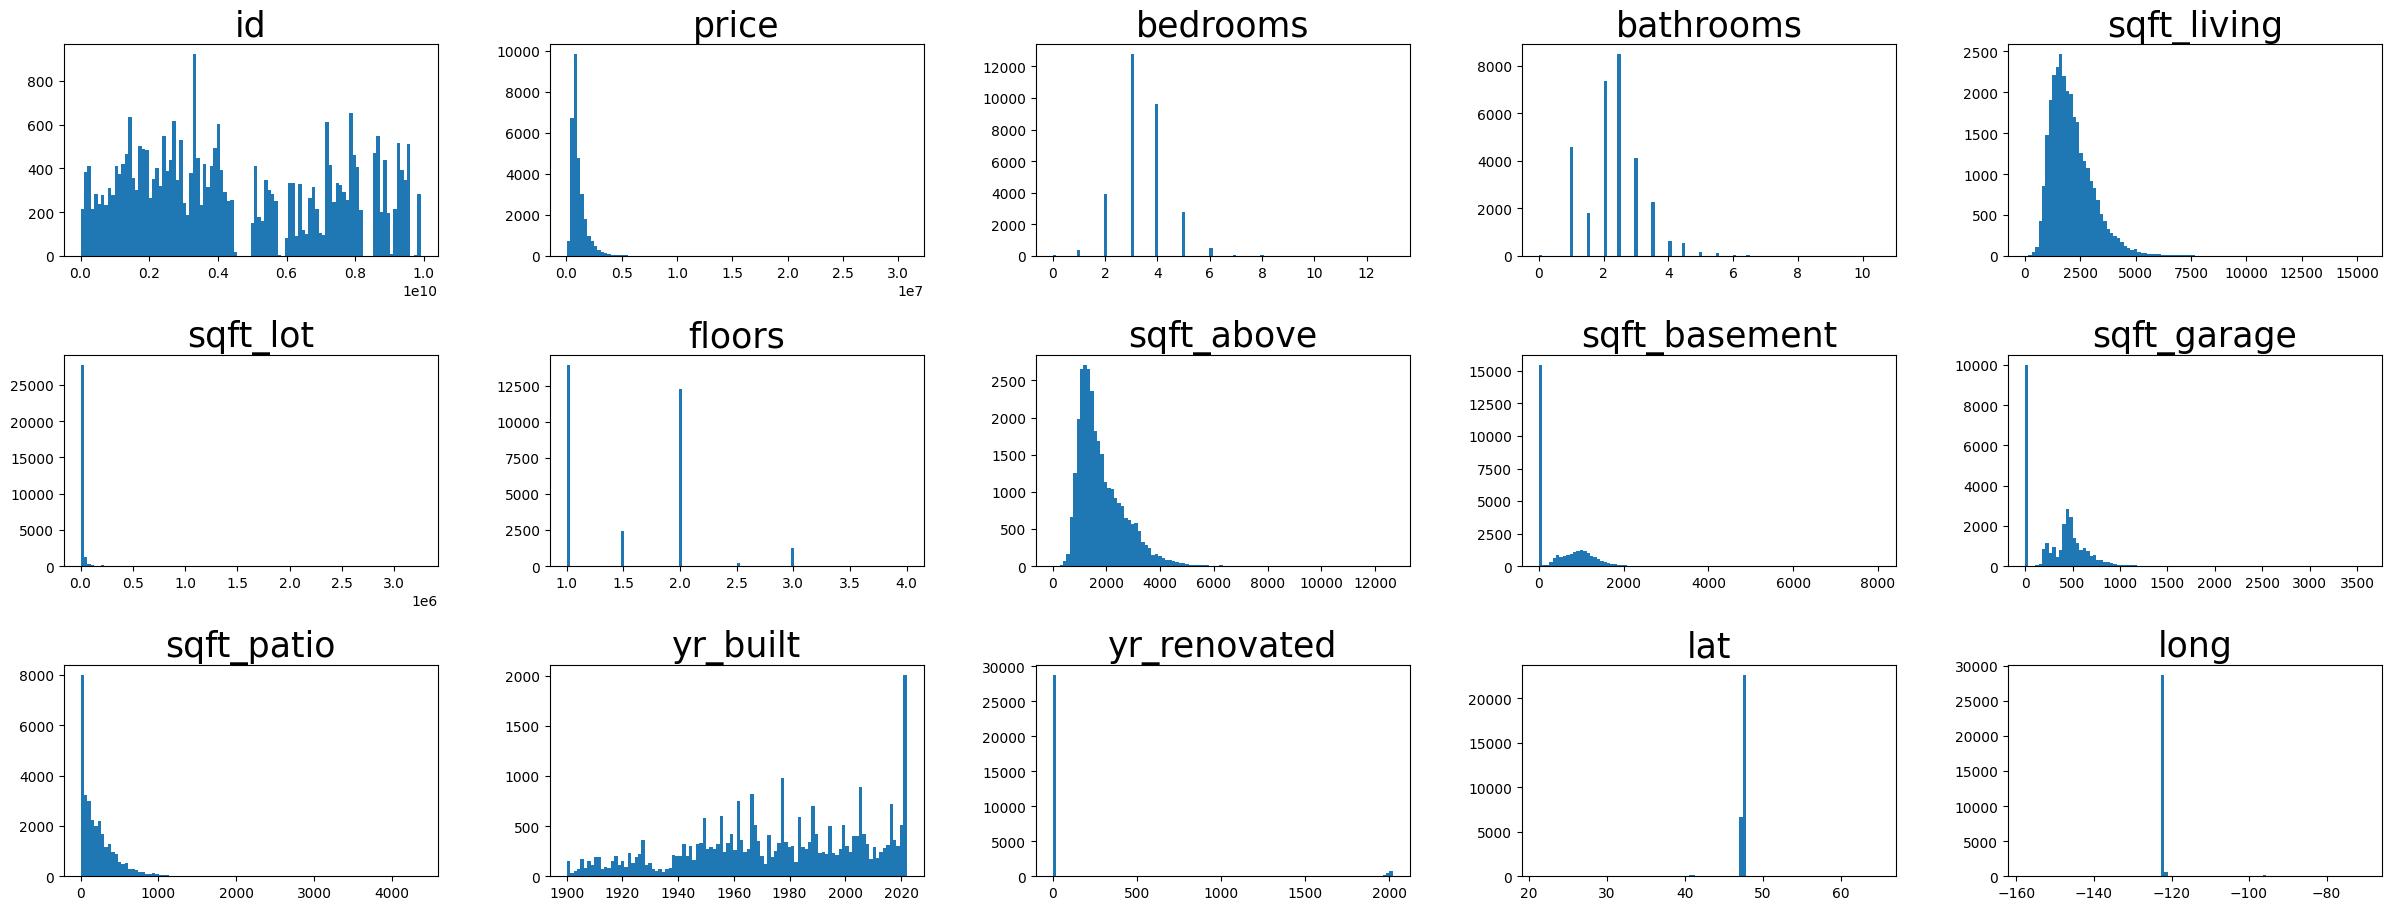

In [1211]:
numerics = houses.select_dtypes(['int64', 'float64'])
hist(numerics, numerics.columns)

In [1212]:
houses = \
houses[
    (houses["price"]<5000000) &
    (houses["price"]>300000) &
    (houses["sqft_living"]>1000) &
    (houses["sqft_living"]<7000) &
    (houses["sqft_above"]>250) &
    (houses["sqft_above"]<6500) &
    (houses["sqft_lot"]<=75000) & 
    (houses['bedrooms']>0) & 
    (houses['bathrooms']>0) &
    (houses.long > -125) & 
    (houses.long < -121.6) & 
    (houses.lat > 47.1) & 
    (houses.lat<47.8)
]

In [1213]:
houses = value_counts(houses)

In [1214]:
len(houses)

25355

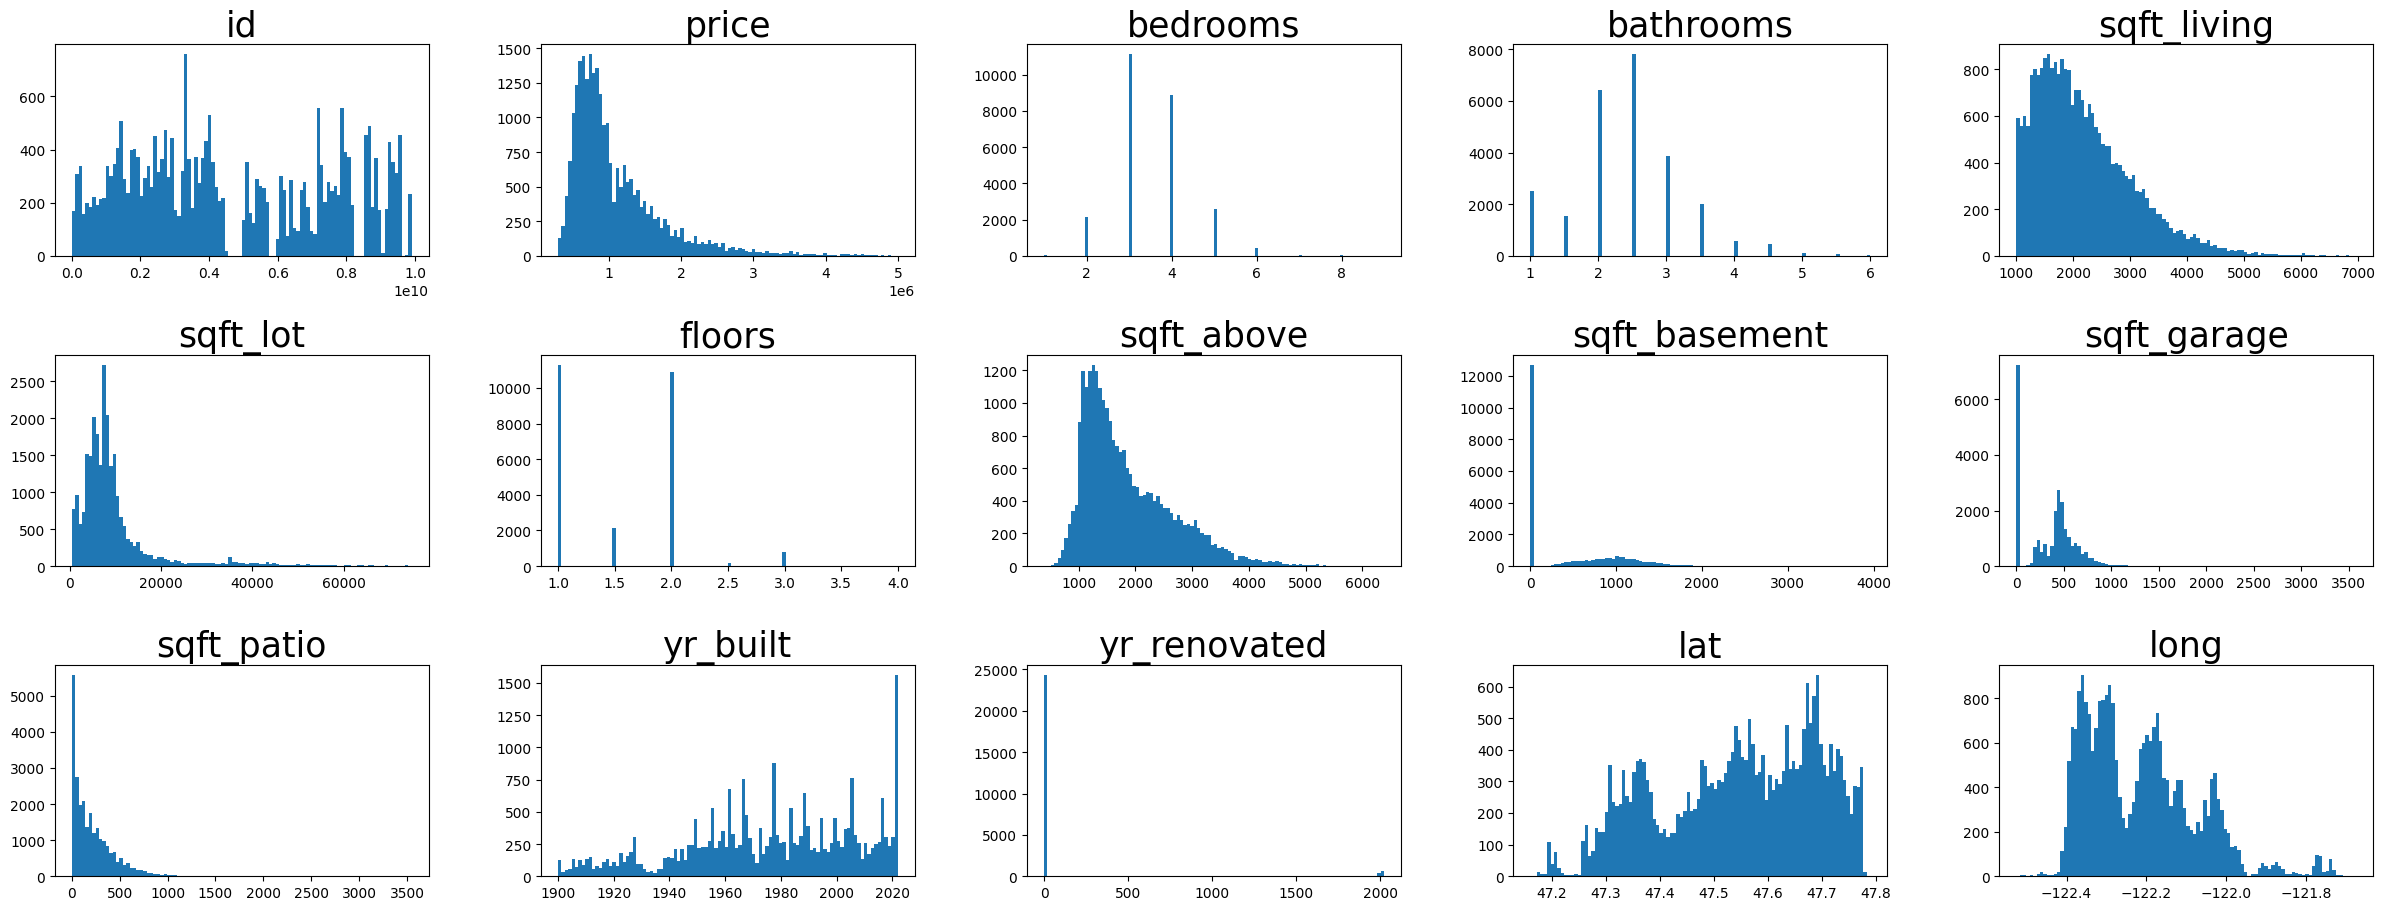

In [1215]:
numerics = houses.select_dtypes(['int64', 'float64'])
hist(numerics, numerics.columns)

In [1216]:
houses.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,lat,long
count,2.535500e+04,2.535500e+04,25355.000000,25355.000000,25355.000000,25355.000000,25355.000000,25355.000000,25355.000000,25355.000000,25355.000000,25355.000000,25355.000000,25355.000000,25355.000000
mean,4.635561e+09,1.103778e+06,3.536936,2.410195,2185.030527,9840.462078,1.549261,1862.246855,496.992546,350.164977,215.325419,1975.985210,80.343088,47.545711,-122.215021
std,2.880935e+09,6.497128e+05,0.902831,0.800997,847.619077,9774.941315,0.548578,797.947313,572.474508,270.686096,230.521972,31.170067,393.050306,0.145793,0.138556
min,1.000094e+06,3.020000e+05,1.000000,1.000000,1001.000000,420.000000,1.000000,390.000000,0.000000,0.000000,0.000000,1900.000000,0.000000,47.159700,-122.525810
25%,2.193320e+09,6.720000e+05,3.000000,2.000000,1540.000000,5000.000000,1.000000,1250.000000,0.000000,0.000000,43.500000,1955.000000,0.000000,47.433420,-122.326770
50%,3.971701e+09,8.975000e+05,3.000000,2.500000,2010.000000,7500.000000,1.500000,1630.000000,0.000000,420.000000,150.000000,1978.000000,0.000000,47.562710,-122.230170
75%,7.336700e+09,1.338625e+06,4.000000,3.000000,2660.000000,10214.000000,2.000000,2320.000000,990.000000,520.000000,310.000000,2003.000000,0.000000,47.672745,-122.129845
max,9.904000e+09,4.995000e+06,9.000000,6.000000,6970.000000,74923.000000,4.000000,6380.000000,3960.000000,3580.000000,3550.000000,2022.000000,2021.000000,47.789830,-121.674690


# Feature Engineering

In this section we will create numerous new variables for testing in the linear regression model.

- The square footage columns for patios, basements and garages have many zeros in them; each zero means the house does not have a patio, basement, or garage (depending on which column you're viewing). These columns weren't very predictive of a house's price (I omit the calculations in this project, but you can find out for yourself), so I used them to create new binary variables for patios, basements, and garages, where a 0 means a house doesn't have one and a 1 means a house does have one.

- A similar column for yr_renovated. The original column either had the year for a house's renovation, or a 0, meaning the house was never renovated. This column was also not very predictive of price, so I created a new binary variable dictating whether or not a house was renovated at all, in the hope this variable would be a better predictor of price.

- I re-mapped some categorical variables to be numerical or binary variables. I wanted to limit myself to numeric variables in this project, because it makes things easier. The "condition", "view", and "grade" variables were among the variables I re-mapped; all made sense as numerical variables, so my changes were justified.

- A coordinate variable which just combines the lat/long columns to form tuples. This variable was not used in any of the models; it was used to create four other variables which were candidates for inclusion in the model.
    - vicinity_price: takes each house in the dataset and computes the average price of other homes close by using the latitude/longitude data.
    - vicinity_density: takes each house in the dataset and computes the number of houses in a small surrounding region. This is a measure of how crowded the house's region is.
    - distance_from_center: computes the house's distance from the center of inhabited territory in King County, WA (the vanishingly small number of houses on the fringes of King County were eliminated before determining the center, as were any houses outside of King County accidentally included in the dataset.)
    - distance_from_bellevue: computes the house's distances from a small area in King County, WA where the houses are the most expensive on average. After looking at a heat map of house price in King County, it seemed like there was a small region where house price jumped way up, and it seemed to go down as you got further away from this region. This region was located in a city called Bellevue, thus the name for the variable.
    
- Initially I had some doubts about the accuracy of the lat/long data because it returned some data points outside of King County, so I created alternatives to the vicinity_density and vicinity_price variables using zipcodes, which were located in the "address" column of the dataset.
    - zipcode was calculated by extracting the zipcodes from the "address" column using a combination of the pandas `map` method and python's built-in string-splitting functionality.
    - zipcode_density was just calculated by taking the number of homes in each zipcode.
    - zipcode_price was calculated for each house by computing the average home price in that house's zipcode, excluding the house in question from that average. This was done to avoid a house helping to predict its own price.

In [1217]:
houses['patio'] = houses['sqft_patio'].map(lambda x: 0 if x == 0 else 1)
houses['basement'] = houses['sqft_basement'].map(lambda x: 0 if x == 0 else 1)
houses['garage'] = houses['sqft_garage'].map(lambda x: 0 if x == 0 else 1)
houses['renovated'] = houses['yr_renovated'].map(lambda x: 0 if x==0 else 1)

houses['condition'] = houses['condition'].map({'Poor': 0, 'Fair': 1, 'Average': 2, 'Good': 3, 'Very Good': 4})
houses['waterfront'] = houses['waterfront'].map({'NO': 0, 'YES': 1})
houses['greenbelt'] = houses['greenbelt'].map({'NO': 0, 'YES': 1})
houses['nuisance'] = houses['nuisance'].map({'NO': 0, 'YES': 1})
houses['view'] = houses['view'].map({'NONE': 0, 'AVERAGE': 1, 'GOOD': 2, 'EXCELLENT': 3, 'FAIR': 4})

houses['grade'] = houses['grade'].map(lambda x: x.split(" ")[0]).astype(int)

# Creating a "coordinate" variable in a lat/long tuple format.
houses['coordinate'] = list(zip(houses['lat'], houses['long']))

# This calculates the distance of every house from the center of inhabited territory.
center = ((houses.lat.min() + houses.lat.max())/2), ((houses.long.min() + houses.long.max())/2)
houses['distance_from_center'] = houses['coordinate'].map(lambda x: geopy.distance.geodesic(x, center).km)

highest_price = (47.62637851929106, -122.22555549295355)
houses['distance_from_bellevue'] = houses['coordinate'].map(lambda x: geopy.distance.geodesic(x, highest_price).km)

In [1218]:
houses['zipcode'] = houses.address.map(lambda x: x.split(',')[-2].split(' ')[-1])

zipcode_prices = []
for i in range(len(houses)):
    zipcode = houses.iloc[i].zipcode
    identifier = houses.iloc[i].id
    subset = houses[(houses.zipcode == zipcode) & (houses.id != identifier)]
    zipcode_price = subset.price.mean()
    zipcode_prices.append(zipcode_price)
    clear_output(wait=True)
    print(f"cell number {i} out of {len(houses)-1} done.")
    
houses['zipcode_price'] = zipcode_prices
houses['zipcode_density'] = houses.zipcode.map(dict(houses.zipcode.value_counts()))

cell number 25354 out of 25354 done.


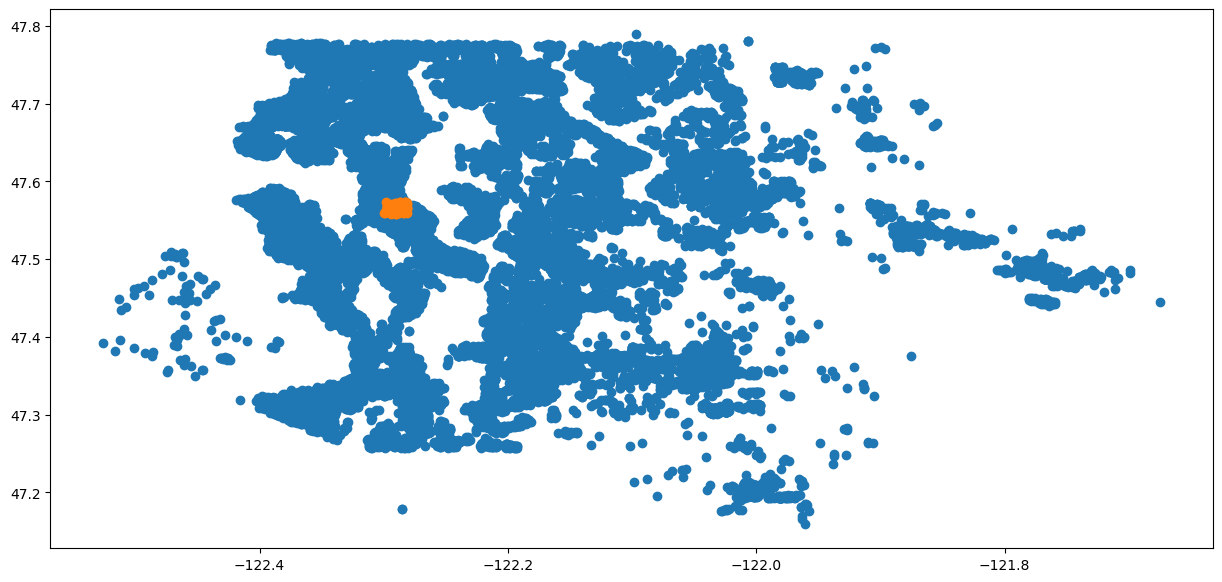

In [1219]:
fig, ax = plt.subplots(figsize=(15,7))

lat_square, long_square, i = 0.00775, 0.01, 3
lat, long = houses.iloc[i].lat, houses.iloc[i].long
area = houses[(houses.lat < lat+lat_square) & 
              (houses.lat > lat-lat_square) & 
              (houses.long < long+long_square) & 
              (houses.long > long-long_square) & 
              (houses.long != long) & 
              (houses.lat != lat)]

ax.scatter(houses.long, houses.lat)
ax.scatter(area.long, area.lat)

In [1220]:
# lat_square = 0.0155
# long_square = 0.02

lat_square = 0.00775
long_square = 0.01

# For every house, we calculate how many houses are in a square-shaped area around them.
# Also, we calculate the average price of houses in that area.
# From this data we get average price of houses in the vicinity as well as the density of that area.
# The house whose price we are trying to predict is eliminated from the mean vicinity price.
# Only houses sold before the target house are included in the mean price.

lengths = []
vicinity_means = []
unusual = []

for i in range(len(houses)):
    lat, long = houses.iloc[i].lat, houses.iloc[i].long
    bedrooms, bathrooms = houses.iloc[i].bedrooms, houses.iloc[i].bathrooms
    sqftsd = houses.sqft_living.std()
    sqftlower = houses.sqft_living.mean() - sqftsd
    sqftupper = houses.sqft_living.mean() + sqftsd
    area = houses[(houses.lat < lat+lat_square) & 
                  (houses.lat > lat-lat_square) & 
                  (houses.long < long+long_square) & 
                  (houses.long > long-long_square) & 
                  (houses.long != long) & 
                  (houses.lat != lat) & 
                  (houses.bedrooms == bedrooms) & 
                  (houses.bathrooms == bathrooms)]
    
    if len(area) == 0:
        area = houses[(houses.lat < lat+lat_square) & 
              (houses.lat > lat-lat_square) & 
              (houses.long < long+long_square) & 
              (houses.long > long-long_square) & 
              (houses.long != long) & 
              (houses.lat != lat) & 
              (houses.sqft_living > sqftlower) & 
              (houses.sqft_living < sqftupper)]
        
    if len(area) == 0:
        area = houses[(houses.lat < lat+lat_square) & 
              (houses.lat > lat-lat_square) & 
              (houses.long < long+long_square) & 
              (houses.long > long-long_square) & 
              (houses.long != long) & 
              (houses.lat != lat)]
        unusual.append(1)
        
    else:
        unusual.append(0)

    lengths.append(len(area))
    vicinity_means.append(area.price.mean())
    
    clear_output(wait=True)
    print(f"cell number {i} out of {len(houses)-1} done.")

cell number 25354 out of 25354 done.


In [1221]:
houses['vicinity_density'] = lengths
houses['vicinity_price'] = vicinity_means
houses['unusual'] = unusual

In [1222]:
houses.dropna(inplace=True)

In [1223]:
df = houses.copy()

to_drop = ['id', 'date', 'yr_renovated', 
         'lat', 'long', 'zipcode', 
         'coordinate', 'address']

usable_vars(df, to_drop)

The list of variables we can use in the linear regression model is: 

 ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'greenbelt', 'nuisance', 'view', 'condition', 'grade', 'heat_source', 'sewer_system', 'sqft_above', 'sqft_basement', 'sqft_garage', 'sqft_patio', 'yr_built', 'patio', 'basement', 'garage', 'renovated', 'distance_from_center', 'distance_from_bellevue', 'zipcode_price', 'zipcode_density', 'vicinity_density', 'vicinity_price', 'unusual']


# Non-linear relationships with price

- bedrooms
- sqft_lot
- floors
- view
- density
- distance_from_center

Other variables we will not use:

- sqft_basement (too many zeros)
- sqft_garage (too many zeros)
- sqft_patio (too many zeros)
- yr_renovated (too many zeroes)
- latitude
- longitude

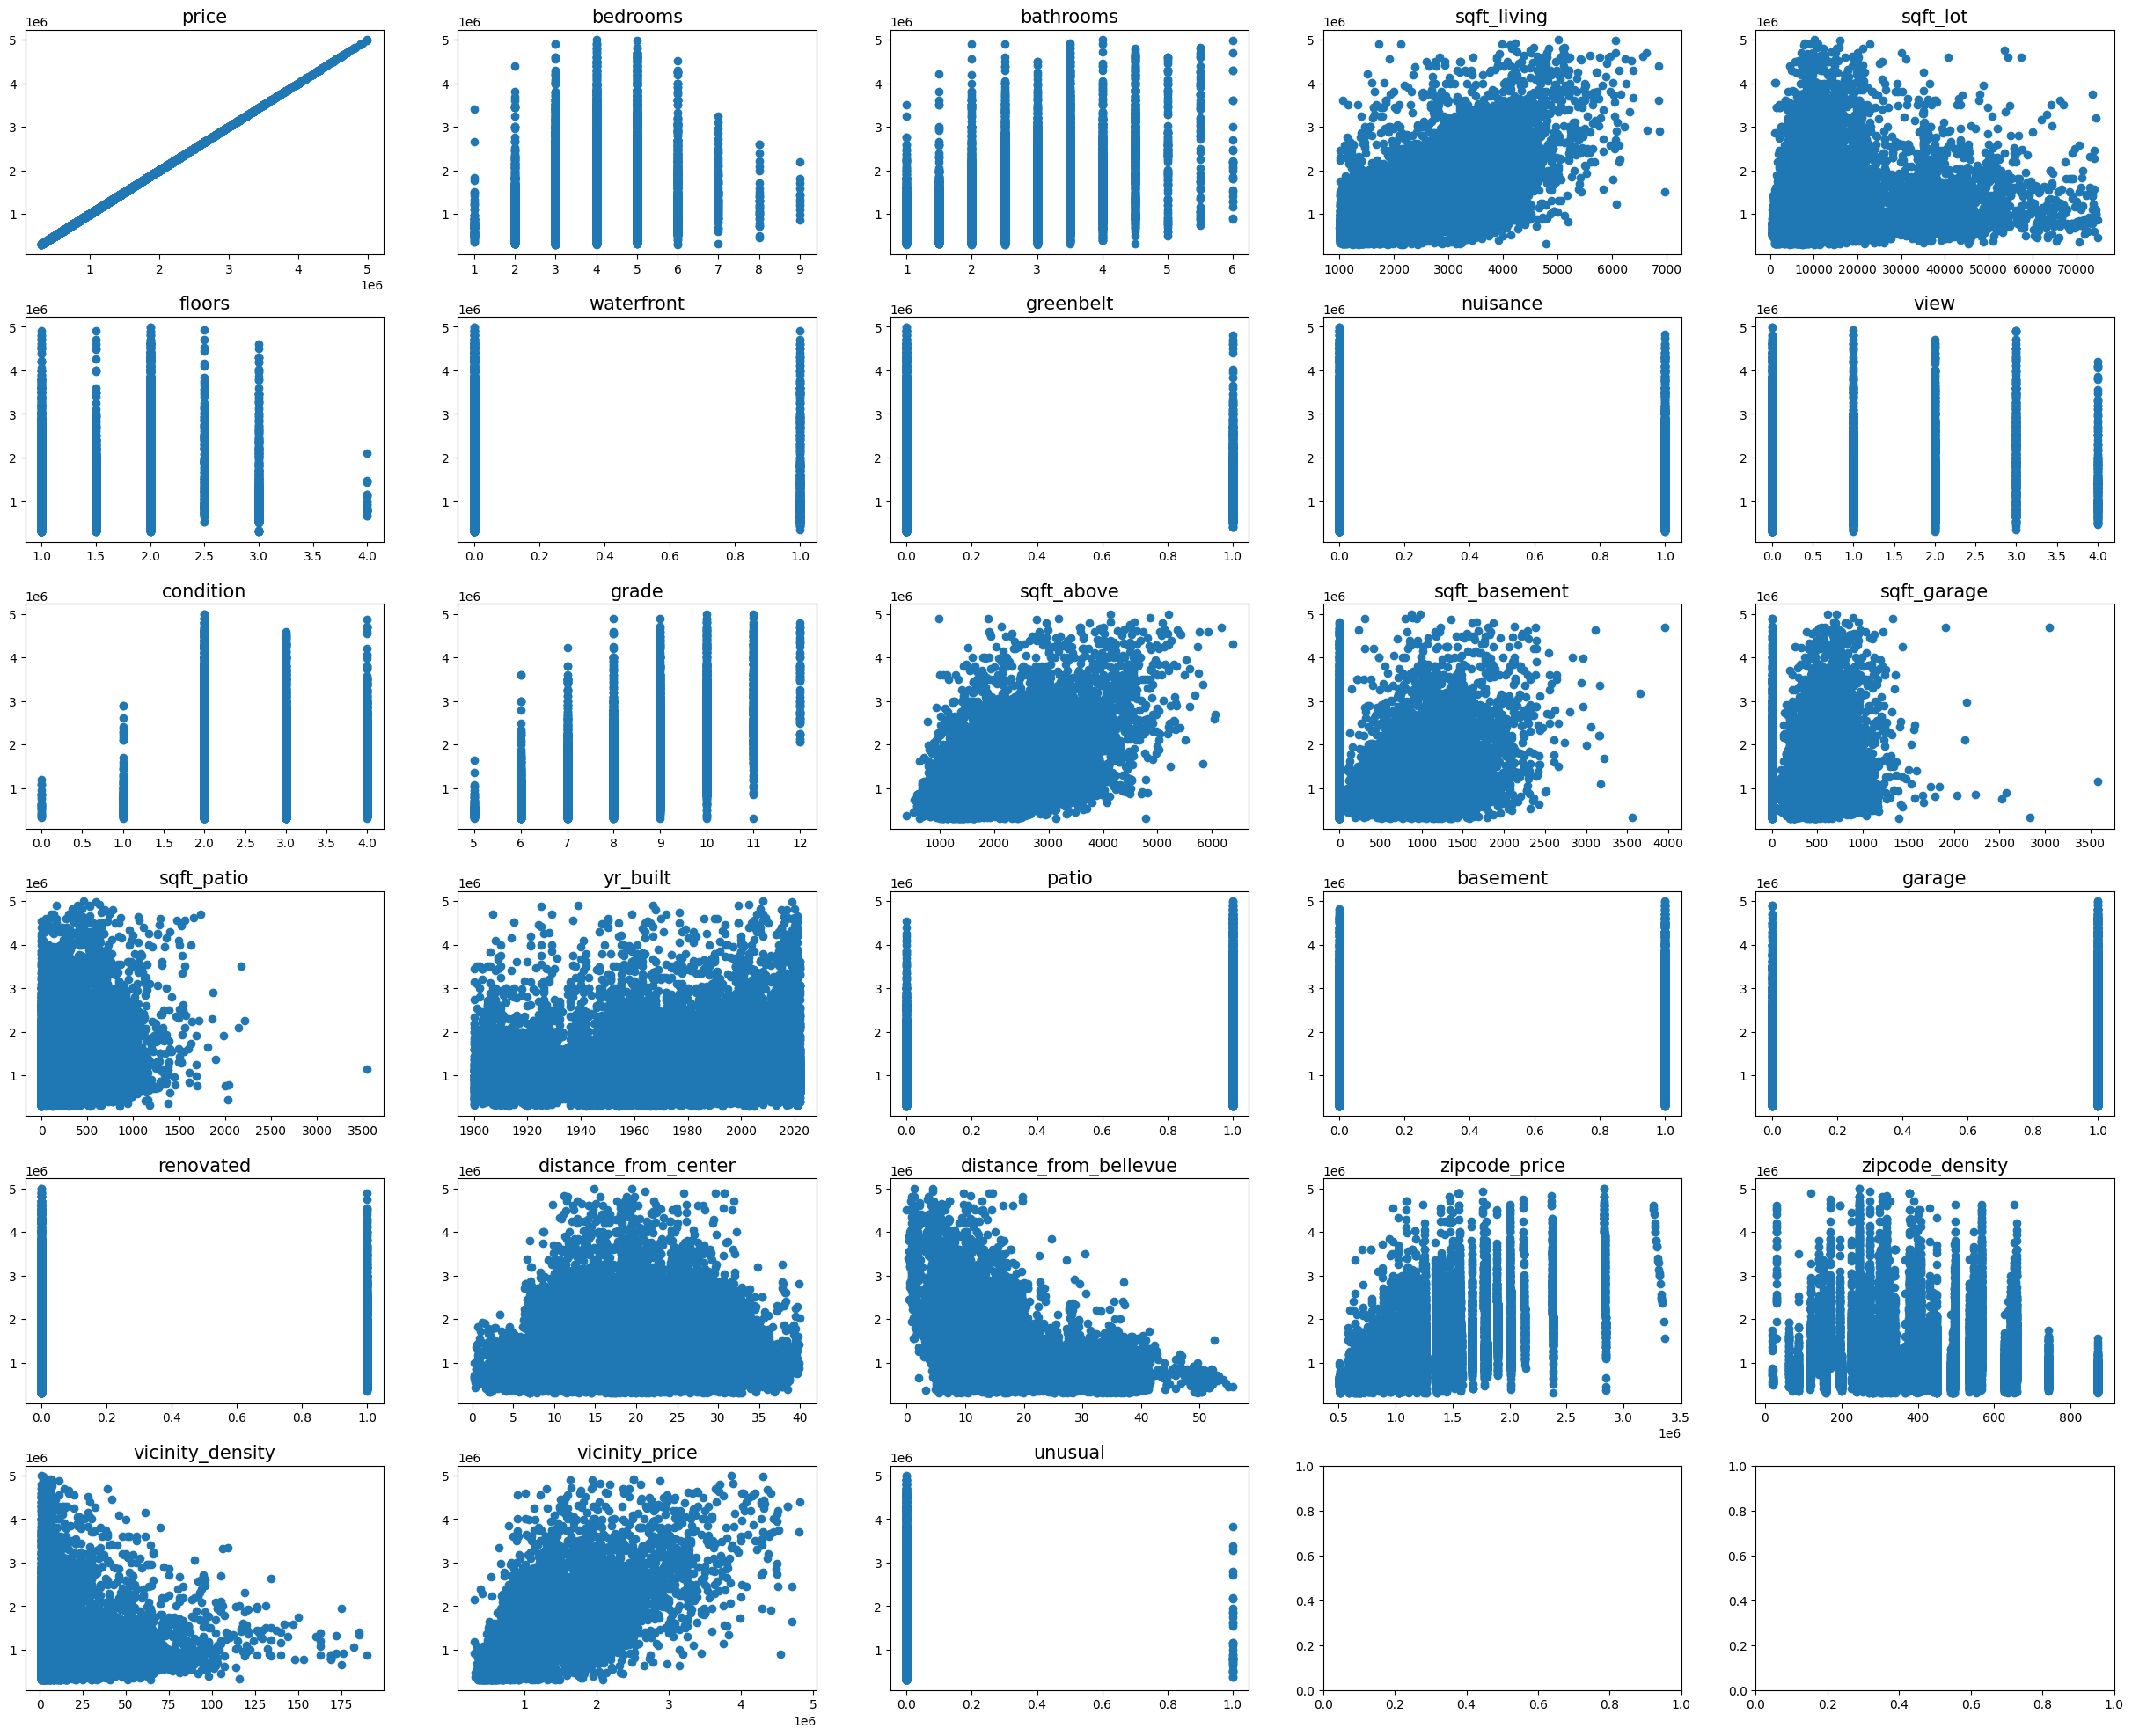

In [1224]:
graph_df = df.drop(to_drop, axis=1).select_dtypes(include=['float64', 'int64'])
scatter(graph_df, graph_df.columns)

In [1225]:
to_drop += ['bedrooms', 'sqft_lot', 'floors', 
         'view', 'zipcode_density', 'distance_from_center', 
         'sqft_basement', 'sqft_garage', 'sqft_patio']

usable_vars(df, to_drop)

The list of variables we can use in the linear regression model is: 

 ['price', 'bathrooms', 'sqft_living', 'waterfront', 'greenbelt', 'nuisance', 'condition', 'grade', 'heat_source', 'sewer_system', 'sqft_above', 'yr_built', 'patio', 'basement', 'garage', 'renovated', 'distance_from_bellevue', 'zipcode_price', 'vicinity_density', 'vicinity_price', 'unusual']


# Eliminating Collinearity and Weak Variables

Variables we are not using due to high collinearity:

- bathrooms
- grade
- sqft_above
- zipcode_price

Variables we are not using due to having an adjusted r-squared value of <0.1 in a linear regression model:

- waterfront
- heat_source
- patio
- vicinity_density
- garage
- basement
- yr_built
- renovated
- greenbelt
- sewer_system
- condition
- nuisance

In [1226]:
strengths = variable_strength(df.drop(to_drop, axis=1), df.drop(to_drop, axis=1).columns)
strengths

,variables,rsquared_adj
0,price,1.000000
19,vicinity_price,0.605175
17,zipcode_price,0.475502
2,sqft_living,0.425102
7,grade,0.398510
10,sqft_above,0.314932
1,bathrooms,0.246240
16,distance_from_bellevue,0.205049
8,heat_source,0.030572
12,patio,0.024964


In [1227]:
to_drop += ['waterfront', 'heat_source', 'patio', 
         'vicinity_density', 'garage', 'basement', 
         'yr_built', 'renovated', 'greenbelt', 
         'sewer_system', 'condition', 'nuisance']

In [1228]:
df.drop(to_drop, axis=1).corr(numeric_only = True)

,price,bathrooms,sqft_living,grade,sqft_above,distance_from_bellevue,zipcode_price,vicinity_price,unusual
price,1.000000,0.496256,0.652016,0.631295,0.561212,-0.452858,0.689581,0.777940,0.013537
bathrooms,0.496256,1.000000,0.728994,0.582491,0.616046,-0.045340,0.226271,0.461812,0.005038
sqft_living,0.652016,0.728994,1.000000,0.689568,0.851858,-0.045666,0.295113,0.520217,0.021461
grade,0.631295,0.582491,0.689568,1.000000,0.677119,-0.142734,0.380484,0.528780,0.015357
sqft_above,0.561212,0.616046,0.851858,0.677119,1.000000,0.076080,0.234219,0.433704,0.030877
distance_from_bellevue,-0.452858,-0.045340,-0.045666,-0.142734,0.076080,1.000000,-0.638255,-0.511481,0.033293
zipcode_price,0.689581,0.226271,0.295113,0.380484,0.234219,-0.638255,1.000000,0.780088,0.000783
vicinity_price,0.777940,0.461812,0.520217,0.528780,0.433704,-0.511481,0.780088,1.000000,0.034608
unusual,0.013537,0.005038,0.021461,0.015357,0.030877,0.033293,0.000783,0.034608,1.000000


In [1229]:
to_drop += ['bathrooms', 'grade', 'sqft_above', 'zipcode_price']
usable_vars(df, to_drop)

The list of variables we can use in the linear regression model is: 

 ['price', 'sqft_living', 'distance_from_bellevue', 'vicinity_price', 'unusual']


In [1230]:
# sqft_mean = df['sqft_living'].mean()
# bellevue_mean = df['distance_from_bellevue'].mean()

# df['price'] = df['price'].map(lambda x: x/100000)

# df['vicinity_price'] = df['vicinity_price'].map(alambda x: x/100000)
# price_mean = df['vicinity_price'].mean()

# df['sqft_living'] = df['sqft_living'].map(lambda x: x - sqft_mean)

# df['distance_from_bellevue'] = df['distance_from_bellevue'].map(lambda x: x - bellevue_mean)

# df['vicinity_price'] = df['vicinity_price'].map(lambda x: x - price_mean)

# Model 1

This model is our most basic model: it only uses a single variable from the dataset. We chose our engineered feature **vicinity_price** because it had the highest adjusted r-squared value of any variable when used to predict price.

The adjusted R-Squared value is suboptimal at 0.523. The mean absolute error is high, at $300,000; the root mean squared error is much, much higher.

In [1231]:
results1 = create_model("price ~ vicinity_price", df)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.605
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                 3.875e+04
Date:                Mon, 03 Jul 2023   Prob (F-statistic):               0.00
Time:                        15:03:20   Log-Likelihood:            -3.6255e+05
No. Observations:               25284   AIC:                         7.251e+05
Df Residuals:                   25282   BIC:                         7.251e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        1.04e+05   5693.418     18.




MAE: 255038.82284862048
RMSE: 166810184060.57217
Average error for normal houses: 254589.91735306187
Average error for unusual houses: 545618.80324294


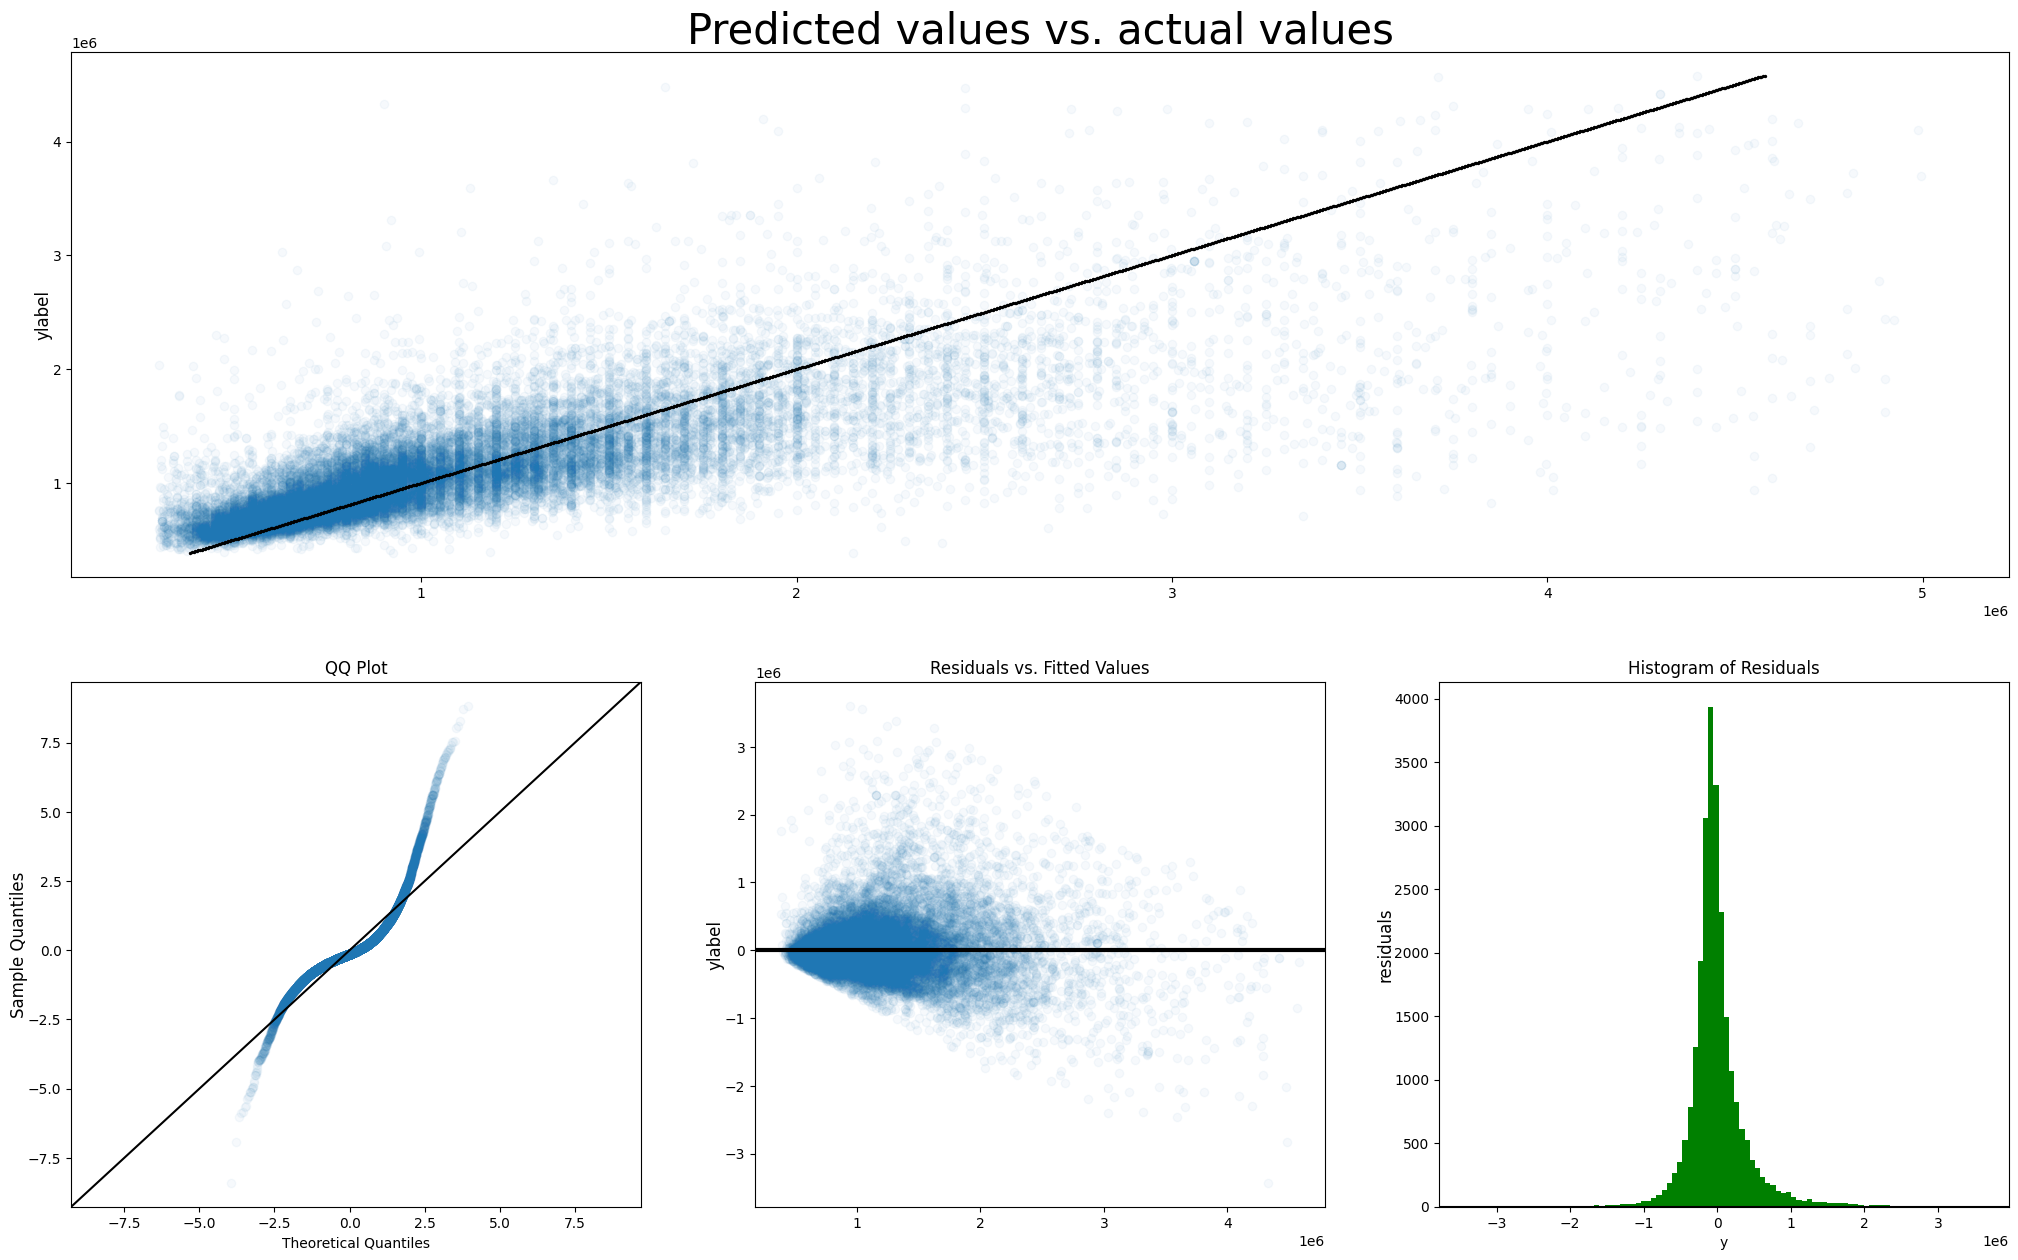

In [1232]:
analyze_model(results1, df)

# Model 2

In this model, we use all the acceptable variables in our linear regression formula: vicinity_price, distance_from_bellevue, and sqft_living.

Our adjusted R-Squared value jumped up from 0.523 to 0.683, a significant improvement. Our mean absolute error and root mean squared error also went down significantly, although they are still very high.

In [1233]:
results2 = create_model("price ~ vicinity_price + sqft_living + distance_from_bellevue", df)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                 2.105e+04
Date:                Mon, 03 Jul 2023   Prob (F-statistic):               0.00
Time:                        15:03:20   Log-Likelihood:            -3.5847e+05
No. Observations:               25284   AIC:                         7.169e+05
Df Residuals:                   25280   BIC:                         7.170e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               5.22




MAE: 229699.42807560993
RMSE: 120798641865.56476
Average error for normal houses: 229466.48158032025
Average error for unusual houses: 380487.48637272243


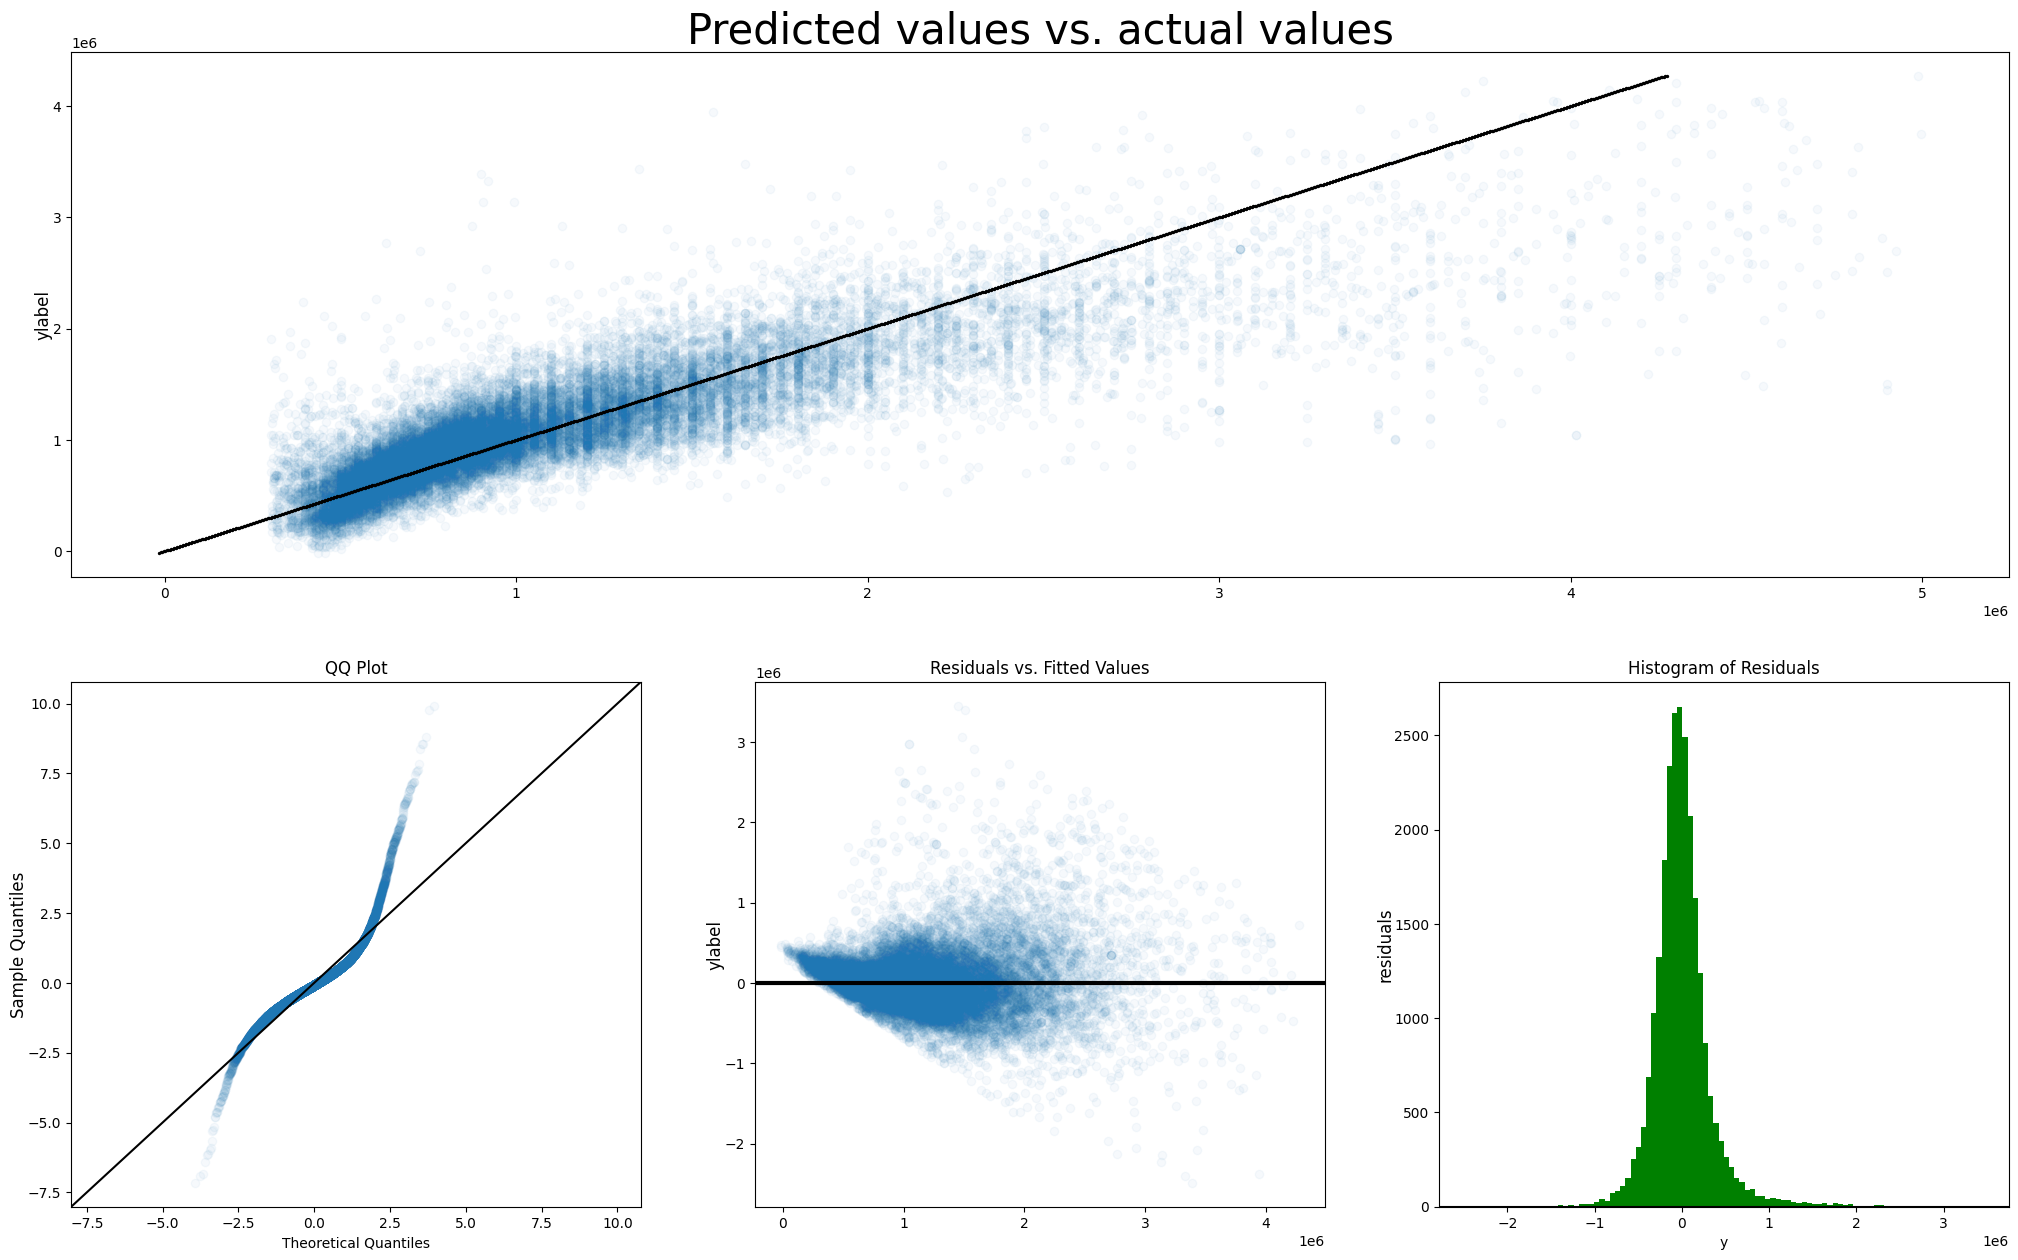

In [1234]:
analyze_model(results2, df)

# Model 3

In an attempt to improve model performance and bring error-based metrics down to reasonable levels, we log-transformed two columns: price, and vicinity_price.

Once again, the adjusted R-Squared value made a significant improvement from 0.683 to 0.768. Our mean absolute error went down to 0.18, and our root mean squared error is 0.06.

Furthermore, our QQ plots and residuals are becoming less irregular as our models progress. They aren't perfect, but they have improved.

In [1235]:
to_log = ['price', 'vicinity_price']

logdf = df.copy()
for col in to_log:
    logdf[col] = np.log(logdf[col])

# logdf['sqft_living'] = logdf['sqft_living'].map(lambda x: x/100)
sqft_mean = logdf['sqft_living'].mean()
logdf['sqft_living'] = logdf['sqft_living'].map(lambda x: x-sqft_mean)

bellevue_mean = logdf['distance_from_bellevue'].mean()
logdf['distance_from_bellevue'] = logdf['distance_from_bellevue'].map(lambda x: x - bellevue_mean)

In [1236]:
results3 = create_model("price ~ vicinity_price + sqft_living + distance_from_bellevue", logdf)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                 2.581e+04
Date:                Mon, 03 Jul 2023   Prob (F-statistic):               0.00
Time:                        15:03:21   Log-Likelihood:                -502.38
No. Observations:               25284   AIC:                             1013.
Df Residuals:                   25280   BIC:                             1045.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  5




MAE: 209926.30977042887
RMSE: 116742866823.64038
Average error for normal houses: 209676.39241409008
Average error for unusual houses: 371699.7369697315


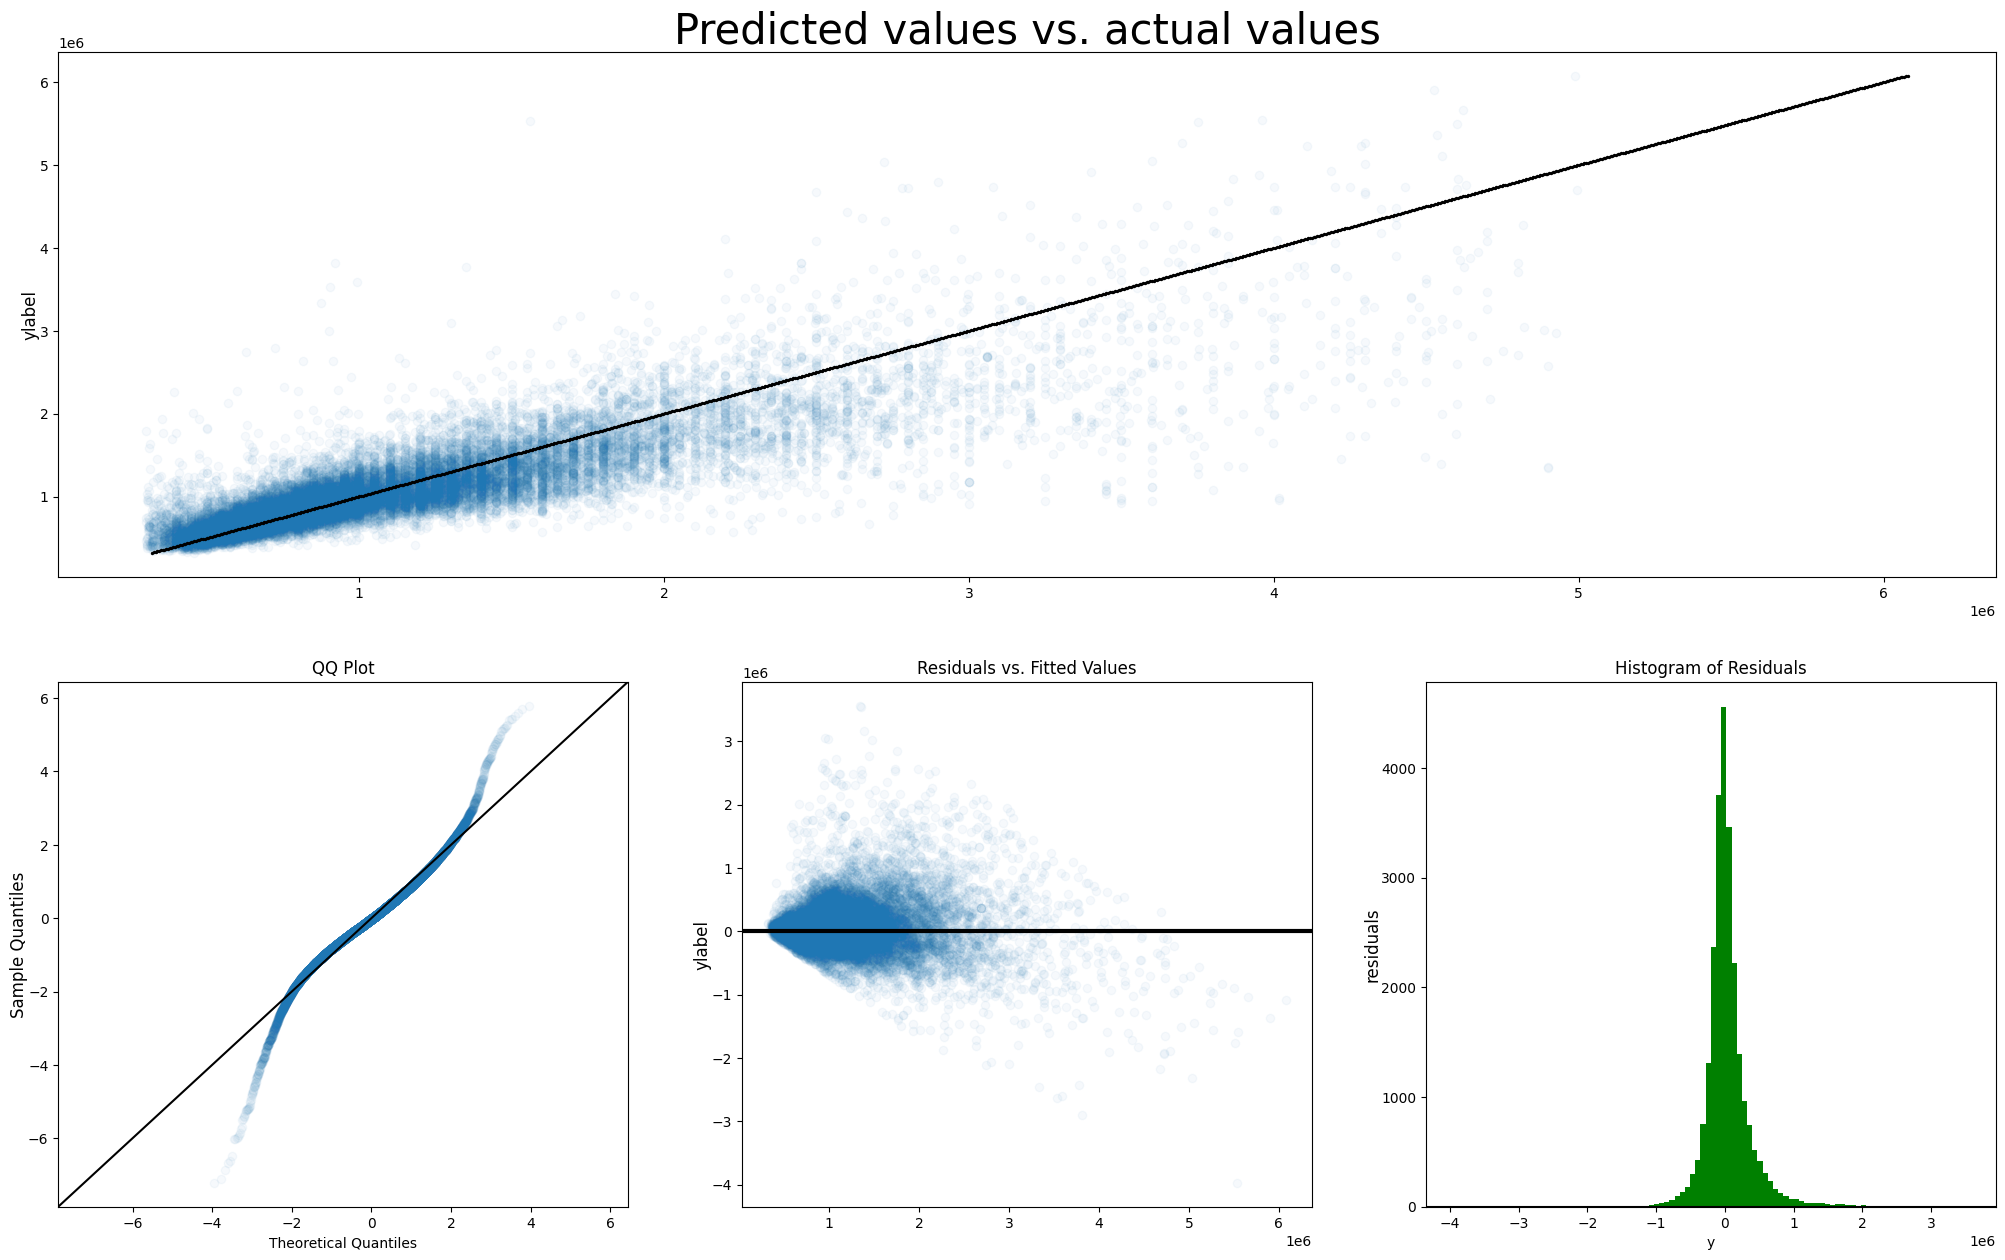

In [1237]:
analyze_model(results3, logdf, log=True)

In [1238]:
X = logdf[['vicinity_price', 'distance_from_bellevue', 'sqft_living']]
y = np.array(logdf['price']).reshape(-1,1)

model = LinearRegression()
model.fit(X, y)
lr_score = model.score(X, y)
lr_score

0.7538474404569677

# Model 3 – Interpretation

In [1239]:
intercept = results.params['Intercept']
vicinity_price = results.params['vicinity_price']
sqft_living = results.params['sqft_living']
distance_from_bellevue = results.params['distance_from_bellevue']

In [1240]:
(np.exp(np.log(1.01) * vicinity_price) - 1) * 100

# For each increase of 1% in vicinity price, we see an associated increase of 0.645% in home price.

0.7008908364211752

In [1241]:
- (1 - np.exp(sqft_living)) * 100

# Every added square foot of living space is associated with an increase of 0.02% in home price.

0.36807057827881184

In [1242]:
- (1 - np.exp(distance_from_bellevue)) * 100

# Every additional kilometer away from Bellevue will decrease the home's price by 0.67%.

-7.680955754194763

# Model 4

In [1243]:
fractionaldf = df.copy()

fractionaldf['price'] = fractionaldf['price'].map(lambda x: x/100000)
fractionaldf['vicinity_price'] = fractionaldf['vicinity_price'].map(lambda x: x/100000)

vicinity_mean = fractionaldf['vicinity_price'].mean()
fractionaldf['vicinity_price'] = fractionaldf['vicinity_price'].map(lambda x: x - vicinity_mean)

sqft_mean = fractionaldf['sqft_living'].mean()
fractionaldf['sqft_living'] = fractionaldf['sqft_living'].map(lambda x: x - sqft_mean)

bellevue_mean = fractionaldf['distance_from_bellevue'].mean()
fractionaldf['distance_from_bellevue'] = fractionaldf['distance_from_bellevue'].map(lambda x: x - bellevue_mean)

In [1244]:
results4 = create_model("price ~ vicinity_price + sqft_living + distance_from_bellevue", fractionaldf)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                 2.105e+04
Date:                Mon, 03 Jul 2023   Prob (F-statistic):               0.00
Time:                        15:03:22   Log-Likelihood:                -67374.
No. Observations:               25284   AIC:                         1.348e+05
Df Residuals:                   25280   BIC:                         1.348e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 11




MAE: 2.2969942807560497
RMSE: 12.079864186556478
Average error for normal houses: 2.294664815803153
Average error for unusual houses: 3.8048748637270977


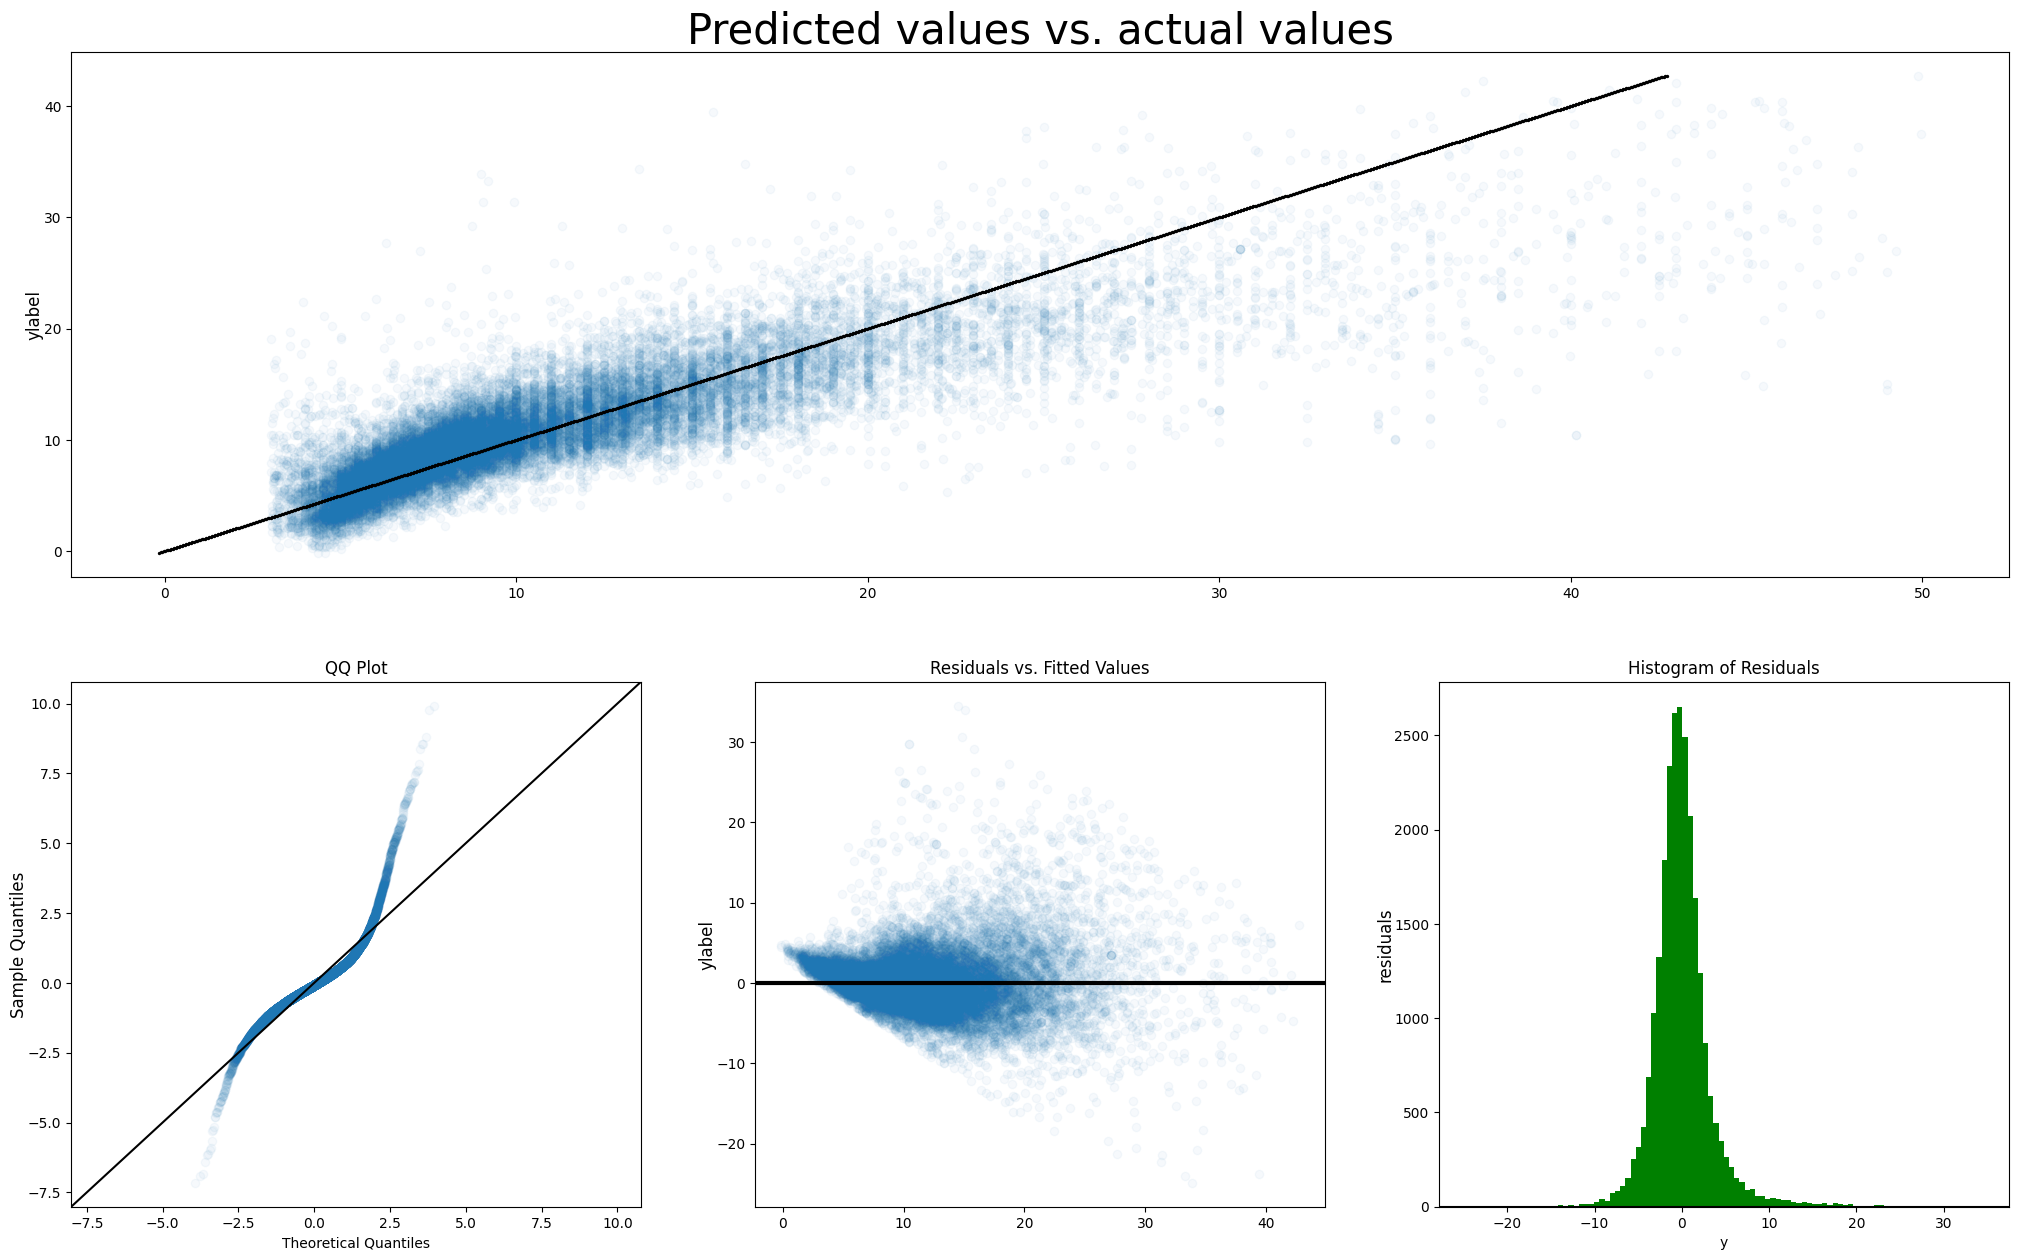

In [1245]:
analyze_model(results4, fractionaldf)

# Model 4 – Interpretation

In [1246]:
len(houses)

25284